In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ray
import ray.rllib

import pyquake.proto
import q1physrl.env

/home/matt/.virtualenvs/100m-rl/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
ray.init()

2020-01-29 20:42:49,928	WARNING worker.py:673 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.
2020-01-29 20:42:49,968	WARNING services.py:597 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-01-29 20:42:50,052	INFO resource_spec.py:216 -- Starting Ray with 0.54 GiB memory available for workers and up to 0.29 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-01-29 20:42:50,421	WARNING services.py:1009 -- Failed to start the reporter. The reporter requires 'pip install psutil'.


{'node_ip_address': '192.168.178.24',
 'redis_address': '192.168.178.24:40827',
 'object_store_address': '/tmp/ray/session_2020-01-29_20-42-49_933190_32026/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-01-29_20-42-49_933190_32026/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2020-01-29_20-42-49_933190_32026'}

In [3]:
trainer = ray.rllib.agents.a3c.A2CTrainer(
    env=q1physrl.env.PhysEnv,
    config={"env_config": {"num_envs": 100}, "gamma": 0.9}
)

2020-01-29 20:42:50,648	INFO trainer.py:371 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2020-01-29 20:42:50,700	INFO trainer.py:512 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2020-01-29 20:42:53,475	WARNING util.py:45 -- Install gputil for GPU system monitoring.
2020-01-29 20:42:53,476	WARNING util.py:48 -- Install psutil to monitor system performance.


In [4]:
# FNAME = '/home/matt/ray_results/A2C_PhysEnv_2020-01-26_18-30-58enaj6dzm/checkpoint_54/checkpoint-54'
# FNAME = '/home/matt/ray_results/A2C_PhysEnv_2020-01-27_21-54-210mybah6w/checkpoint_38/checkpoint-38'
# FNAME = '/home/matt/ray_results/A2C_PhysEnv_2020-01-29_18-38-4507_f9y9o/checkpoint_42/checkpoint-42'
# FNAME = '/home/matt/ray_results/A2C_PhysEnv_2020-01-29_18-48-34d96of62s/checkpoint_147/checkpoint-147'
# FNAME = '/home/matt/ray_results/A2C_PhysEnv_2020-01-29_19-42-287sgxfik5/checkpoint_20/checkpoint-20'
FNAME = '/home/matt/ray_results/A2C_PhysEnv_2020-01-29_20-03-30jpgozu93/checkpoint_209/checkpoint-209'

trainer.restore(FNAME)

2020-01-29 20:42:53,657	INFO trainable.py:346 -- Restored from checkpoint: /home/matt/ray_results/A2C_PhysEnv_2020-01-29_20-03-30jpgozu93/checkpoint_209/checkpoint-209
2020-01-29 20:42:53,662	INFO trainable.py:353 -- Current state after restoring: {'_iteration': 209, '_timesteps_total': 9944200, '_time_total': 2120.6089248657227, '_episodes_total': 27600}


In [5]:
DEMO_FILE_NAME = "wr8.dem"

In [6]:
import asyncio
loop = asyncio.get_running_loop()
task = loop.create_task(q1physrl.env.eval_coro(26000, trainer, DEMO_FILE_NAME))

In [7]:
raise Exception

(pid=32073) /home/matt/.virtualenvs/100m-rl/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
(pid=32073)   warnings.warn(msg)
(pid=32072) /home/matt/.virtualenvs/100m-rl/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
(pid=32072)   warnings.warn(msg)
(pid=32073) /home/matt/.virtualenvs/100m-rl/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
(pid=32073)   warnings.warn(msg)
(pid=32072) /home/matt/.virtualenvs/100m-rl/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma modu

Exception: 

In [8]:
obs, action = task.result()

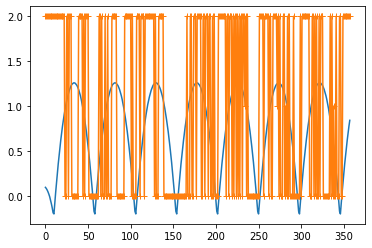

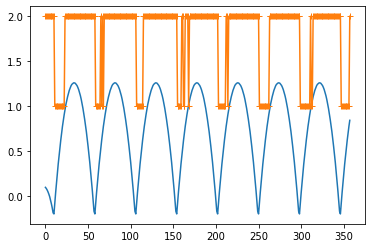

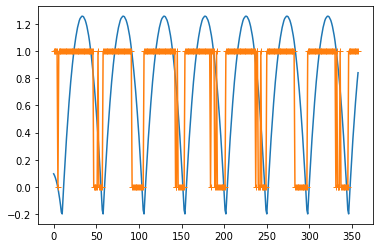

In [26]:
for a in action.T:
    plt.plot(obs[:, 1] / 30 - 1)
    plt.plot(np.arange(len(a)), a, marker='+')
    plt.show()

Take the actions from the above run and push them through the PhysEnv.
Comparing the observations will reveal potential bugs.

In [ ]:
env = q1physrl.env.PhysEnv({'num_envs': 1})
o, = env.vector_reset()

obs2= [o]

for a in action:
    (o,), _, _, _ = env.vector_step(a[None])
    obs2.append(o)
    
obs2 = np.stack(obs2[:-1])    

In [ ]:
plt.plot(np.max(np.abs(obs - obs2), axis=1))
# plt.plot(np.argmax(np.abs(obs - obs2), axis=1))

Open the demo file we just made, and measure the speed

In [9]:
view_entity = None
origin = None
origins = []
times = []

time = None

def patch_vec(old_vec, update):
    return tuple(v if u is None else u for v, u in zip(old_vec, update))

with open(DEMO_FILE_NAME, 'rb') as f:
    for angles, msg in pyquake.proto.read_demo_file(f):
        if msg.msg_type == pyquake.proto.ServerMessageType.SETVIEW:
            view_entity = msg.viewentity
        if (msg.msg_type == pyquake.proto.ServerMessageType.SPAWNBASELINE and
                msg.entity_num == view_entity):
            origin = msg.origin
        if (msg.msg_type == pyquake.proto.ServerMessageType.UPDATE and
                msg.entity_num == view_entity):
            origin = patch_vec(origin, msg.origin)
            origins.append(origin)
            times.append(time)
        if msg.msg_type == pyquake.proto.ServerMessageType.TIME:
            time = msg.time

In [10]:
np.diff(np.array([o[1] for o in origins])).sum()

943.875

ERROR:asyncio:Task was destroyed but it is pending!
task: <Task pending coro=<AsyncClient._read_messages() running at /home/matt/pyquake/pyquake/client.py:215> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0x7f6bd1022b58>()]> cb=[AsyncClient.connect.<locals>.<lambda>() at /home/matt/pyquake/pyquake/client.py:303]>


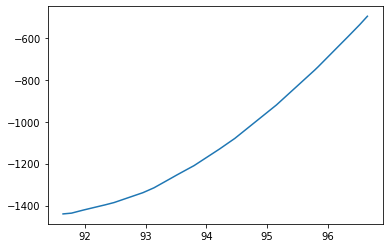

In [11]:
plt.plot(times, [o[1] for o in origins])

In [13]:
np.diff([o[1] for o in origins][-100:]).mean() / 0.014

284.27128427128423